# Tides

Notebook for analysing high and low tide measurement data for several locations in Germany.

Data source is Wasser- und Schifffahrtsverwaltung des Bundes (WSV) provided by Bundesanstalt für Gewässerkunde (BfG).

In [1]:
%matplotlib inline

import glob

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['svg.fonttype'] = 'none'

Read in tide `.zrx` files. It's basically CSV with some weird meta data stuff on top.

Drop bad datasets and convert columns into categoricals.

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d%H%M%S')

def parse_meta_data(filename):
    meta_info = []
    with open(filename, encoding='latin1') as f:
        for line in f:
            if not line.startswith('#'):
                break
            meta_info.extend(line[1:].split('|*|'))
    return [m for m in meta_info if m]


def read_tide(filename):
    print(filename)
    df = pd.read_csv(filename, comment='#', sep=' ',
                     header=None, names=['timestamp', 'value', ''],
                     usecols=['timestamp', 'value'],
                     parse_dates=[0], date_parser=dateparse)

    meta_info = parse_meta_data(filename)
    name = [m for m in meta_info if m.startswith('SNAME')]
    if name:
        name = name[0][len('SNAME'):]
        df['name'] = name
    else:
        df['name'] = None
    file_type = filename.split('.')[0].split('-')[-1]
    df['type'] = file_type
    
    df['filename'] = filename
    return df
    

filenames = glob.glob('Tnw+Thw-*/*.zrx')

# Drop Zehnerloch, because it's broken
filenames.remove('Tnw+Thw-2/Zehnerloch-Thw.zrx')

# Drop duplicate file Krautsand
filenames.remove('Tnw+Thw-2/Krautsand-Thw.zrx')
filenames.remove('Tnw+Thw-2/Krautsand-Tnw.zrx')

df = pd.concat([read_tide(f) for f in filenames])

# Drop Tönning from data, because it doesn't make sense, quote WSV:
# „Da die Wasserstandsdaten des Pegels Tönning durch das Eidersperrwerk
# beeinflusst sind, erscheint eine Darstellung in dem
# Diagramm „Hochwasser an deutschen Küsten von 1950 bis 2014“ hydrologisch
# nicht sinnvoll. Ich schlage vor, die MThw-Ganglinie des Pegels Tönning aus
# dem Diagramm zu entfernen.
df = df[df['name'] != 'TÖNNING']

df['type'] = df['type'].astype('category')
df['filename'] = df['filename'].astype('category')
df['name'] = df['name'].astype('category')
df.describe()

Tnw+Thw-1/BÅsum-Thw.zrx
Tnw+Thw-1/BÅsum-Tnw.zrx
Tnw+Thw-1/DagebÅll-Thw.zrx
Tnw+Thw-1/DagebÅll-Tnw.zrx
Tnw+Thw-1/Helgoland-Binnenhafen-Thw.zrx
Tnw+Thw-1/Helgoland-Binnenhafen-Tnw.zrx
Tnw+Thw-1/Husum-Thw.zrx
Tnw+Thw-1/Husum-Tnw.zrx
Tnw+Thw-2/BHV-Alter-Leuchtturm-Thw.zrx
Tnw+Thw-2/BHV-Alter-Leuchtturm-Tnw.zrx
Tnw+Thw-2/Borkum-Fischerbalje-Thw.zrx
Tnw+Thw-2/Borkum-Fischerbalje-Tnw.zrx
Tnw+Thw-2/Borkum-SÅdstrand-Thw.zrx
Tnw+Thw-2/Borkum-SÅdstrand-Tnw.zrx
Tnw+Thw-2/Brokdorf-Thw.zrx
Tnw+Thw-2/Brokdorf-Tnw.zrx
Tnw+Thw-2/Cuxhaven-Steubenhîft-Thw.zrx
Tnw+Thw-2/Cuxhaven-Steubenhîft-Tnw.zrx
Tnw+Thw-2/Eider-Sperrwerk-AP-Thw.zrx
Tnw+Thw-2/Eider-Sperrwerk-AP-Tnw.zrx
Tnw+Thw-2/Emshîrn-Thw.zrx
Tnw+Thw-2/Emshîrn-Tnw.zrx
Tnw+Thw-2/HH-St-Pauli-Thw.zrx
Tnw+Thw-2/HH-St-Pauli-Tnw.zrx
Tnw+Thw-2/Hîrnum-Thw.zrx
Tnw+Thw-2/Hîrnum-Tnw.zrx
Tnw+Thw-2/Kollmar-Thw.zrx
Tnw+Thw-2/Kollmar-Tnw.zrx
Tnw+Thw-2/List-Thw.zrx
Tnw+Thw-2/List-Tnw.zrx
Tnw+Thw-2/LT-Alte-Weser-Thw.zrx
Tnw+Thw-2/LT-Alte-Weser-Tnw.zrx
Tnw+

,value
count,3509635.000000
mean,505.339357
std,153.032677
min,-777.000000
25%,357.000000
50%,536.000000
75%,644.000000
max,1149.000000


In [3]:
# Assumption is: these values are incorrect
INVALID_VALUES = [-777, 0]
df = df[~df.value.isin(INVALID_VALUES)]
df.describe()

,value
count,3509621.000000
mean,505.344251
std,153.012842
min,70.000000
25%,357.000000
50%,536.000000
75%,644.000000
max,1149.000000


In [4]:
df['time'] = pd.to_datetime(df["timestamp"]).astype(int).astype(float)

In [5]:
df.name.value_counts()

CUXHAVEN/STEUBENHÖFT      162671
BORKUM SÜDSTRAND          112806
WHV ALTER VORHAFEN        112493
WITTDÜN                   111751
HUSUM                     111749
DAGEBÜLL                  111693
BÜSUM                     111280
LIST                      110924
HÖRNUM                    110924
HELGOLAND BINNENHAFEN     101768
HAMBURG-ST.PAULI           92923
PAPENBURG                  92804
EMDEN NEUE SEESCHLEUSE     92804
POGUM                      92804
Zollenspieker              92687
SCHULAU                    92687
STADERSAND                 92448
KOLLMAR                    91749
BROKDORF                   91748
NORDENHAM                  84570
GLÜCKSTADT                 78570
SCHARHÖRN                  78102
MELLUMPLATE                74574
NORDERNEY RIFFGAT          73279
BORKUM-FISCHERBALJE        72224
LEUCHTTURM ALTE WESER      71865
BHV ALTER LEUCHTTURM       70455
WEENER                     64218
HECHTHAUSEN                62583
MITTELGRUND                62575
BELUM     

In [6]:
len(df)

3509621

In [7]:
len(df.columns)

6

In [8]:
# Check for duplicate values
df_thw = df[(df.type == 'Thw')]
duplicated_thw = df_thw[['name', 'timestamp']].duplicated()
assert len(df_thw[duplicated_thw].sort_values(['name', 'timestamp'])) == 0

## Plotting

To quickly plot the different locations we groupby name and timestamp (which is a unique criteria for each row so the mean is not a real mean), unstack and transpose, and resample to create a table as seen below.

In [9]:
plot_data = df[(df.timestamp.dt.year >= 1950) & 
               (df.type == 'Thw')
              ].groupby(['name', 'timestamp']).value.mean().unstack().T.resample('A', how='mean')

# Try out different means
# plot_data = df.groupby(['name', 'timestamp']).value.mean().unstack().T.rolling_mean()
# plot_data = pd.rolling_max(plot_data, window=3, min_periods=1)
# plot_data = df.groupby(['timestamp', 'name']).value.resample('1W', how='mean')
plot_data.tail()


name,Altengamme,BELUM,BHV ALTER LEUCHTTURM,BORKUM SÜDSTRAND,BORKUM-FISCHERBALJE,BROKDORF,BÜSUM,CUXHAVEN/STEUBENHÖFT,DAGEBÜLL,DUKEGAT,...,SCHULAU,SPIEKEROOG,STADERSAND,VOSLAPP,WANGEROOGE NORD,WANGEROOGE WEST,WEENER,WHV ALTER VORHAFEN,WITTDÜN,Zollenspieker
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,779.845609,657.062411,684.504965,606.448227,620.141844,659.425532,665.282270,656.446809,644.855319,634.537589,...,697.330028,649.422695,684.821530,670.578723,642.324823,649.492199,684.733333,686.855319,628.093617,761.910765
2012-12-31,765.913720,654.442716,683.418670,605.677511,618.096181,655.828854,662.520509,653.476662,640.432815,632.196605,...,692.391796,646.981612,681.685997,670.140028,640.690240,649.178218,682.353607,685.216407,623.510608,751.328147
2013-12-31,790.022695,651.943262,681.405674,604.930595,615.749292,655.947518,659.107801,651.368794,636.649645,628.627479,...,695.120567,645.733711,683.048227,668.801700,638.449008,647.443343,680.226629,684.313031,621.479433,759.496454
2014-12-31,754.502128,651.035411,684.002833,608.530496,619.615603,653.209632,661.501416,651.781870,640.264873,632.448227,...,688.513475,650.219858,676.974504,672.655319,642.272340,652.005674,682.835461,686.310638,626.164306,744.479433
2015-12-31,775.314286,672.396552,690.282732,607.155598,NaN,NaN,NaN,662.545977,NaN,634.328571,...,700.219149,651.917143,693.346705,676.037143,643.585714,654.045714,688.500000,690.645714,NaN,753.774468


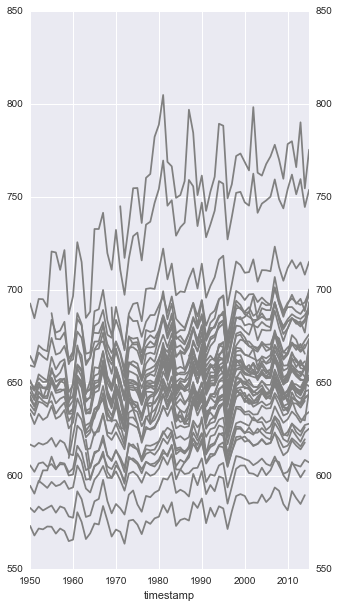

In [10]:
fig  = plt.figure(figsize=(5, 10))
ax = plt.subplot(111)

plot_data.plot(ax=ax, color='gray', legend=False)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')

In [11]:
# Check the mean of first 20 values and last twenty values
pd.DataFrame([plot_data[:20].mean(), plot_data[-20:].mean()]).T

,0,1
name,,
Altengamme,NaN,769.857219
BELUM,NaN,654.903545
BHV ALTER LEUCHTTURM,673.183848,681.463162
BORKUM SÜDSTRAND,596.715981,605.930338
BORKUM-FISCHERBALJE,605.934877,617.490063
BROKDORF,643.388525,655.393909
BÜSUM,648.285235,661.877310
CUXHAVEN/STEUBENHÖFT,641.126751,654.183913
DAGEBÜLL,619.077696,640.231626


To properly plot, let's check out when measurements started/ended for the locations.

In [12]:
first_measurement = df.groupby(['name']).timestamp.first()
stations_1970 = first_measurement[first_measurement.dt.year <= 1970]
stations_1950 = first_measurement[first_measurement.dt.year <= 1950]
# stations_1970
first_measurement.sort_values()

name
CUXHAVEN/STEUBENHÖFT     1900-01-01 00:16:00
WHV ALTER VORHAFEN       1934-02-18 01:36:00
BORKUM SÜDSTRAND         1935-10-31 01:00:00
WITTDÜN                  1935-10-31 03:10:00
BÜSUM                    1935-10-31 14:58:00
DAGEBÜLL                 1935-10-31 15:45:00
HELGOLAND BINNENHAFEN    1935-10-31 15:45:00
HUSUM                    1935-10-31 15:53:00
HÖRNUM                   1936-06-01 11:10:00
LIST                     1936-06-01 11:42:00
EMDEN NEUE SEESCHLEUSE   1949-10-01 07:48:00
POGUM                    1949-10-01 08:08:00
PAPENBURG                1949-10-01 09:55:00
KOLLMAR                  1950-01-01 00:40:00
STADERSAND               1950-01-01 01:15:00
SCHULAU                  1950-01-01 01:57:00
HAMBURG-ST.PAULI         1950-01-01 02:42:00
Zollenspieker            1950-01-01 03:45:00
BROKDORF                 1950-01-01 12:37:00
NORDENHAM                1955-11-01 01:52:00
GLÜCKSTADT               1959-11-01 02:32:00
ZEHNERLOCH               1959-11-01 07:10:00
SCHAR

Cuxhaven location has the most data, trend seems pretty clear.

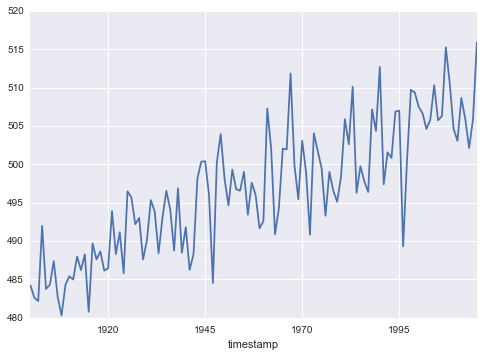

In [13]:
df[df.name == 'CUXHAVEN/STEUBENHÖFT'].set_index('timestamp').value.resample('1A', how='mean').plot()

Let's take all high tide data between 1971 and 2014 (inclusive) from all stations that provide data since 1970.
Resample to one year and round.

In [14]:
data = df[(df.type == 'Thw') &
          (df.timestamp.dt.year >= 1971) &
          (df.timestamp.dt.year <= 2014) &
          (df.name.isin(stations_1970.index))].groupby(['name', 'timestamp']).value.mean().unstack().T
data = data.resample('1A', how='mean').apply(np.round)
# data = pd.rolling_mean(data.resample("1M", how='mean'), window=12, min_period=1)
data.head()

name,BELUM,BHV ALTER LEUCHTTURM,BORKUM SÜDSTRAND,BORKUM-FISCHERBALJE,BROKDORF,BÜSUM,CUXHAVEN/STEUBENHÖFT,DAGEBÜLL,EMDEN NEUE SEESCHLEUSE,GLÜCKSTADT,...,NORDERNEY RIFFGAT,PAPENBURG,POGUM,SCHARHÖRN,SCHULAU,STADERSAND,WEENER,WHV ALTER VORHAFEN,WITTDÜN,Zollenspieker
timestamp,,,,,,,,,,,,,,,,,,,,,
1971-12-31,644,666,598,602,642,649,642,619,631,640,...,608,659,634,634,660,651,651,666,610,711
1972-12-31,633,655,592,597,629,640,631,614,624,629,...,602,653,626,625,648,641,644,658,605,697
1973-12-31,650,675,601,610,647,656,648,628,642,648,...,617,669,643,641,668,660,660,675,616,717
1974-12-31,649,671,602,608,646,655,647,627,639,648,...,615,669,640,636,671,662,659,674,617,729
1975-12-31,649,671,600,606,646,654,647,626,637,644,...,614,667,639,634,672,660,658,674,614,731


### Export different data subsets to CSV

In [15]:
data_1950 = df[(df.type == 'Thw')
          & (df.timestamp.dt.year >= 1951)
          & (df.timestamp.dt.year <= 2014)
          & (df.name.isin(stations_1950.index))]
len(data_1950)

857337

In [16]:
data_1950_grouped = data_1950.groupby(['name', 'timestamp']).value.mean().unstack().T
data_1950_grouped = data_1950_grouped.resample('1A', how='mean').apply(np.round)
print(len(data_1950_grouped.columns))
data_1950_grouped.T.to_csv('../chart/data/data_1950.csv', encoding='utf-8')

19


In [17]:
data_1970 = df[(df.type == 'Thw')
          & (df.timestamp.dt.year >= 1971)
          & (df.timestamp.dt.year <= 2014)
          & (df.name.isin(stations_1970.index))]
len(data_1970)

962671

In [18]:
data_1970_grouped = data_1970.groupby(['name', 'timestamp']).value.mean().unstack().T
data_1970_grouped = data_1970_grouped.resample('1A', how='mean').apply(np.round)
print(len(data.columns))
data_1970_grouped.T.to_csv('../chart/data/data_1970.csv', encoding='utf-8')

31


In [19]:
data_1970_grouped_5a = data_1970.groupby(['name', 'timestamp']).value.mean().unstack().T
# data = data.resample('5A', how='mean').apply(np.round)
data_1970_grouped_5a = pd.rolling_mean(data_1970_grouped_5a.resample("1A", how='mean'), window=10, min_periods=1).apply(np.round)
print(len(data_1970_grouped_5a.columns))
data_1970_grouped_5a.T.to_csv('../chart/data/data_1970_5a.csv', encoding='utf-8')

31


In [20]:
data = df[(df.type == 'Thw')
          & (df.timestamp.dt.year >= 1951)
          & (df.timestamp.dt.year <= 2014)
          & (df.name.isin(stations_1950.index))
         ].groupby(['name', 'timestamp']).value.mean().unstack().T
# data = data.resample('5A', how='mean').apply(np.round)
data = pd.rolling_mean(data.resample("1A", how='mean'), window=10, min_periods=1).apply(np.round)
data.T.to_csv('../chart/data/data_1950_5a.csv', encoding='utf-8')

In [21]:
# Cuxhaven data
cuxhaven_data = df[(df.type == 'Thw') & (df.name == 'CUXHAVEN/STEUBENHÖFT')]
print(len(cuxhaven_data))
(cuxhaven_data.groupby(['name', 'timestamp']).value.mean().unstack().T
         .resample('1A', how='mean').apply(np.round)
         .T.to_csv('../chart/data/cuxhaven.csv', encoding='utf-8'))

81336


### Plot a grid of charts

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


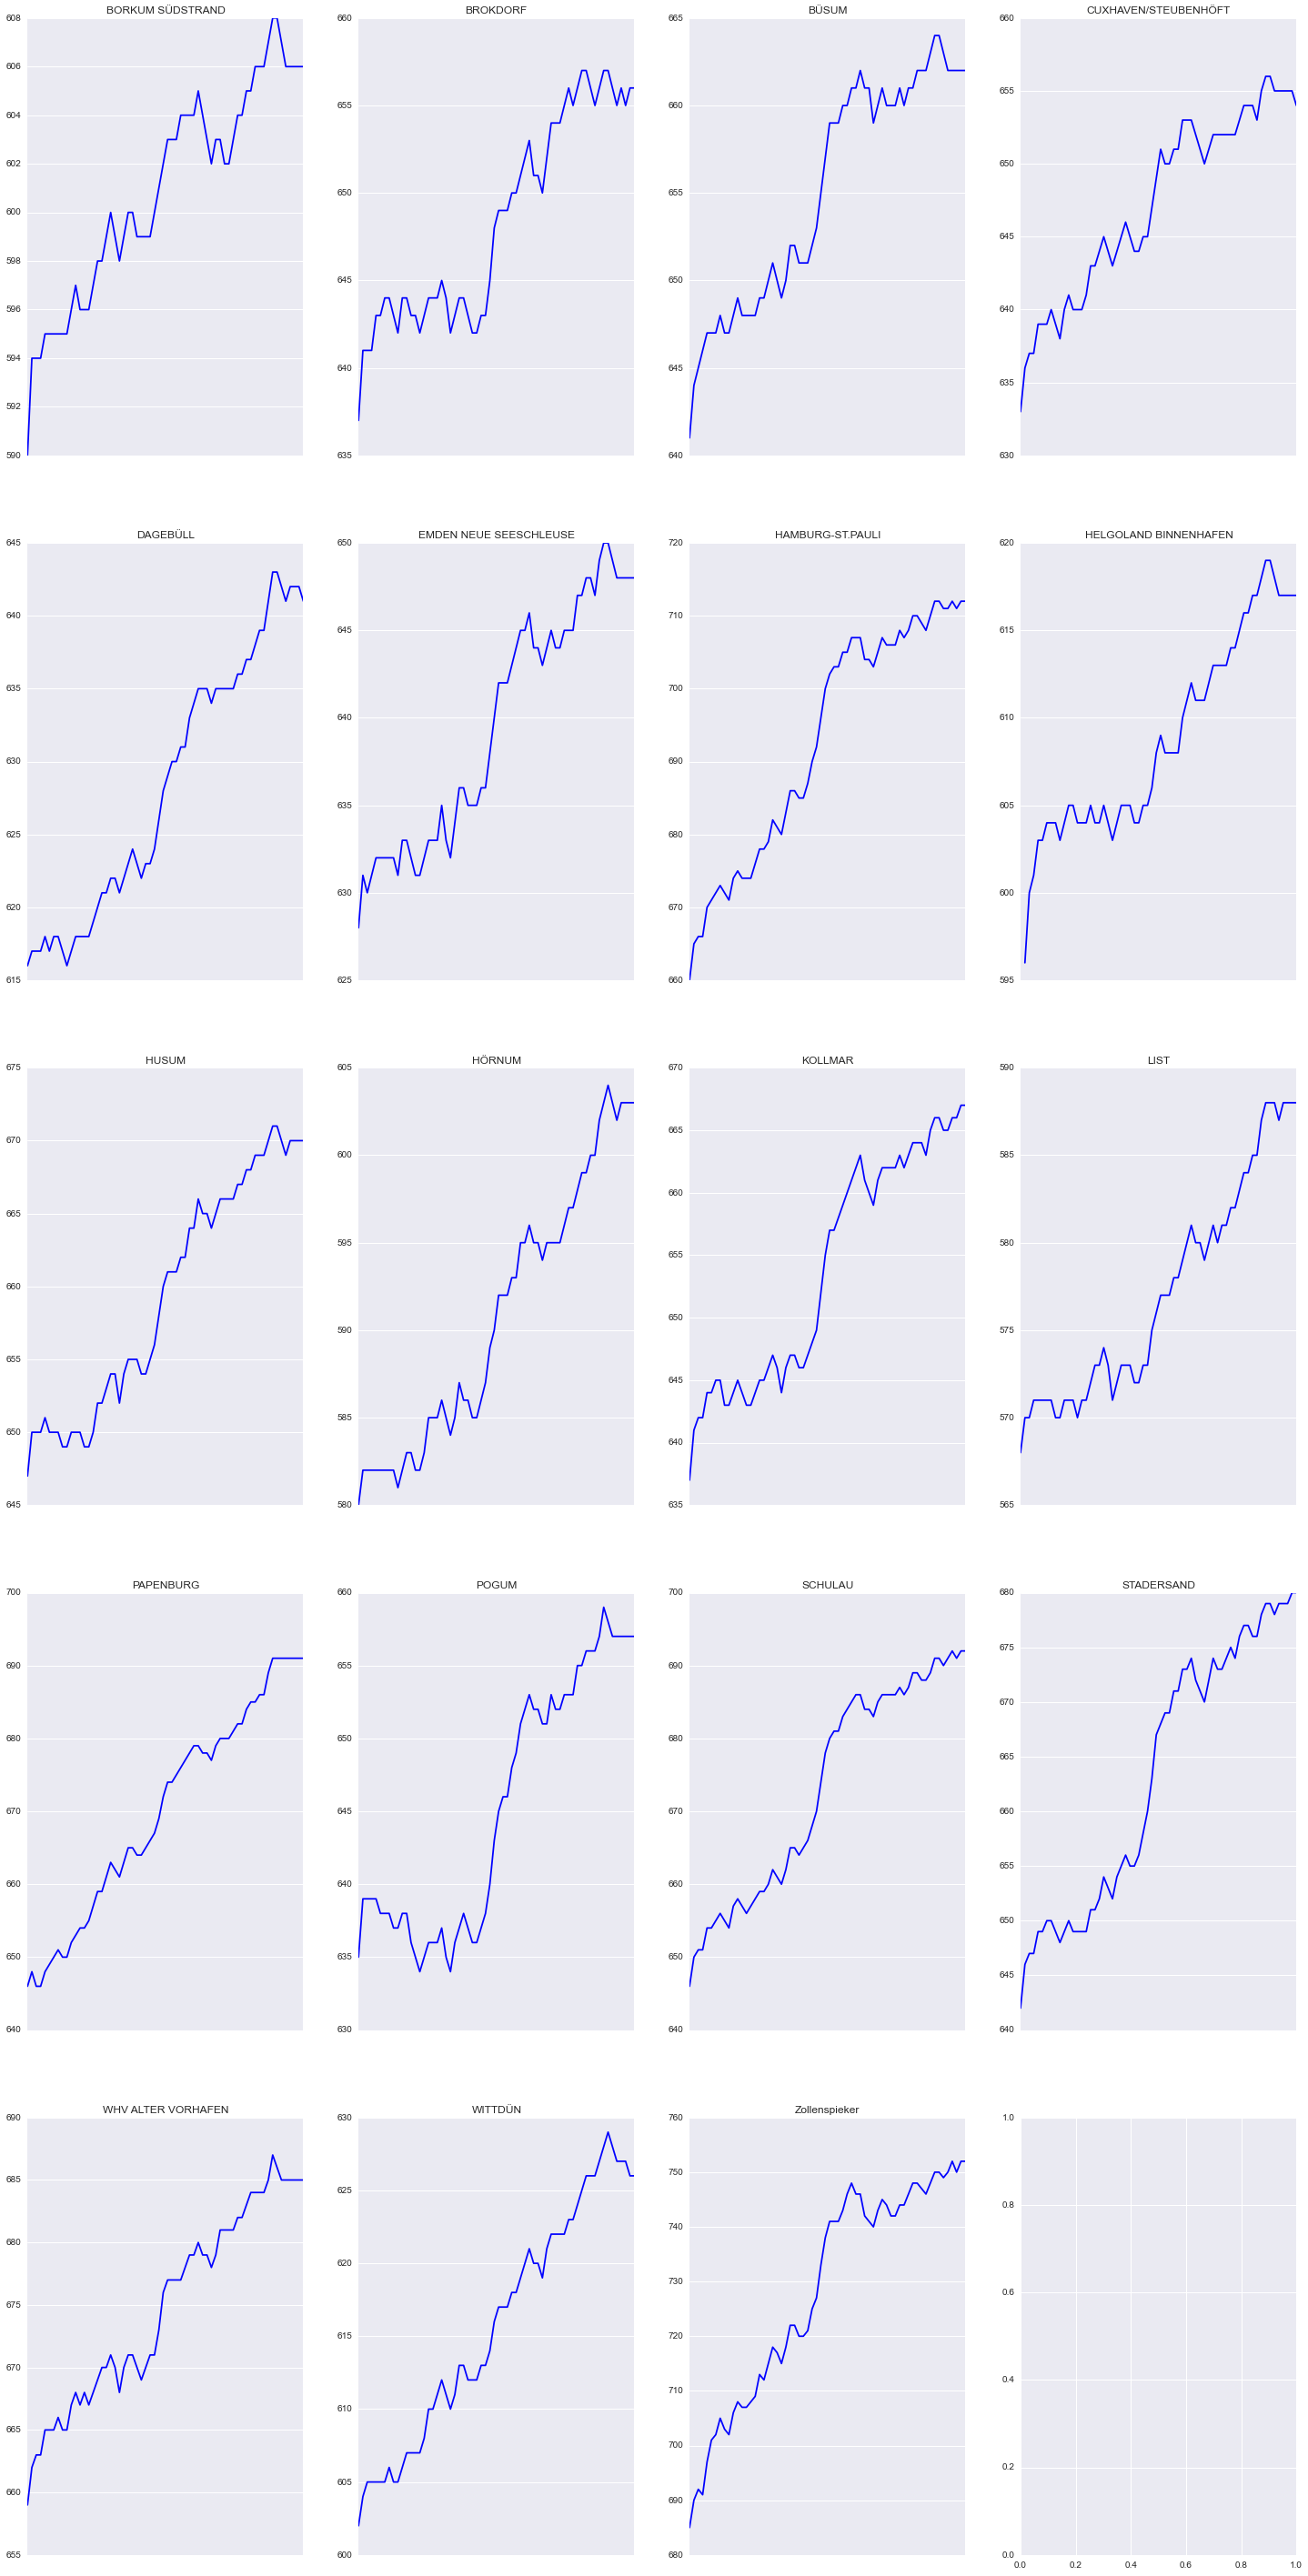

In [22]:
def plot_grid(df, cols=4, **kwargs):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / cols)), ncols=cols)
    fig.set_figheight(6)
    fig.set_figwidth(8)

    for i, x in enumerate(df.columns):
        ax = axes[i // cols, i % cols]
        df[x].plot(ax=ax, color='blue', legend=False, label=False,
                   kind='line', stacked=False, sharex=False,
                   figsize=(25, 50))
        ax.set_title(x)
        ax.xaxis.set_visible(False)
    return fig

fig = plot_grid(data)
fig.show()